Initial PE: 614977325.4648108
Optimization terminated successfully.
         Current function value: -287.645913
         Iterations: 947
         Function evaluations: 986
         Gradient evaluations: 986
Optimized PE: -287.64591315780893
 Step  PotEng   KinEng   TotEng   Temp 
    0 -287.646  181.332 -106.314 1.813
   10 -195.155  151.264  -43.891 1.513
   20 -162.860  168.213    5.353 1.682
   30 -177.934  198.023   20.090 1.980
   40 -196.801  210.934   14.134 2.109
   50 -181.475  193.381   11.906 1.934
   60 -175.568  192.517   16.949 1.925
   70 -167.698  191.798   24.100 1.918
   80 -158.851  190.349   31.498 1.903
   90 -147.865  189.617   41.752 1.896
  100 -137.180  191.028   53.848 1.910
  110 -139.796  196.959   57.162 1.970
  120 -132.425  193.907   61.482 1.939
  130 -117.419  188.190   70.771 1.882
  140 -127.854  201.632   73.778 2.016
  150 -126.707  200.154   73.447 2.002
  160 -118.667  196.744   78.077 1.967
  170 -108.069  192.850   84.780 1.928
  180 -125.065  

 2050 -104.323  202.927   98.605 2.029
 2060 -105.224  201.952   96.728 2.020
 2070 -109.471  203.919   94.448 2.039
 2080 -100.112  193.880   93.768 1.939
 2090 -113.020  205.742   92.722 2.057
 2100 -103.030  197.553   94.523 1.976
 2110 -113.045  207.379   94.335 2.074
 2120 -110.399  202.087   91.688 2.021
 2130  -89.596  186.216   96.620 1.862
 2140 -113.599  208.774   95.175 2.088
 2150  -94.672  191.866   97.194 1.919
 2160 -109.466  204.499   95.033 2.045
 2170  -92.091  193.659  101.568 1.937
 2180 -101.432  203.318  101.886 2.033
 2190 -101.516  202.506  100.990 2.025
 2200  -92.489  196.196  103.707 1.962
 2210 -101.301  198.269   96.968 1.983
 2220 -107.296  200.378   93.082 2.004
 2230 -107.366  200.064   92.698 2.001
 2240 -110.793  201.976   91.182 2.020
 2250 -101.804  199.013   97.208 1.990
 2260 -105.576  203.866   98.290 2.039
 2270 -110.415  205.701   95.286 2.057
 2280 -110.306  198.045   87.739 1.980
 2290 -108.241  202.464   94.224 2.025
 2300 -111.942  206.291  

 4210 -105.040  206.994  101.954 2.070
 4220  -90.420  191.697  101.277 1.917
 4230 -101.564  202.248  100.684 2.022
 4240  -98.012  200.979  102.968 2.010
 4250  -96.354  203.429  107.075 2.034
 4260  -92.310  193.435  101.125 1.934
 4270 -110.027  208.457   98.429 2.085
 4280 -101.137  202.752  101.615 2.028
 4290  -98.180  199.237  101.057 1.992
 4300 -103.536  202.782   99.246 2.028
 4310 -100.049  198.521   98.472 1.985
 4320 -103.491  203.325   99.834 2.033
 4330 -104.693  203.275   98.582 2.033
 4340 -106.840  200.297   93.457 2.003
 4350 -105.461  201.982   96.521 2.020
 4360 -118.473  205.978   87.505 2.060
 4370 -106.454  198.024   91.571 1.980
 4380 -110.790  200.871   90.082 2.009
 4390 -106.946  204.424   97.478 2.044
 4400 -100.145  193.770   93.625 1.938
 4410 -112.730  202.048   89.318 2.020
 4420  -93.502  188.687   95.185 1.887
 4430  -88.244  191.705  103.460 1.917
 4440  -95.122  195.291  100.170 1.953
 4450 -104.733  204.400   99.666 2.044
 4460  -91.183  191.095  

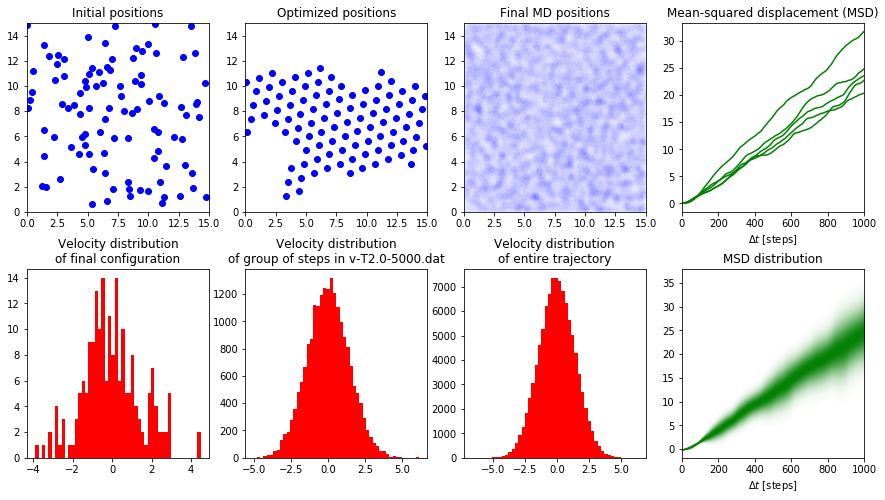

In [3]:
#!/usr/bin/env python
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform
import scipy.optimize as optim

#Simulation parameters:
L = 15.        #Simulation box size in reduced LJ units
N = 100        #Number of particles in box
T = 2.0        #Temperature in reduced LJ units
nSteps = 5000  #Total number of time steps in simulation

#Data collection parameters:
collectInterval = 10  #Output velocities and print energies every so-many steps
outputIntervalV = 1000 #Output velocity files every so-many steps (of data collected at collectInterval)
outputIntervalD = 1000 #Output mean-squared displacement vs time based on blocks of so-many steps


class MD:
    """
    Class that performs simple MD with LJ potentials.
    Note that the class itself supports much more general functionality,
    including simulation in 3 or higher dimensions, than what we use for this course.
    """
    
    def __init__(self, L):
        """
        Initialize simulation for d-dimensional box of length L (LJ units).
        Note d is set by the pos passed in various functions below.
        """
        self.L = L
    
    def pairPotential(self, pos):
        """
        Return potential energy and force on all atoms (Nxd array) given positions, pos (Nxd array).
        Potential is LJ with epsilon = sigma = 1 with minimum-image convention (effective cutoff ~ L/2).
        """
        x = (1./self.L)*(pos[None,...] - pos[:,None,:]) #NxNxd array of fractional relative positions
        x = self.L*(x-np.floor(0.5+x)) #apply minimum-image convention and convert back to Cartesian
        rInv2 = 1./squareform(np.sum(x**2, axis=-1)) #pairwise inverse squared distance
        rInv6 = rInv2**3 #squareform above makes these N*(N-1)/2 vector instead of NxN
        rInv12 = rInv6**2
        pe = 4.*np.sum(rInv12 - rInv6) #total potential energy (scalar)
        forces = 24.*np.sum(squareform((rInv6 -2.*rInv12)*rInv2)[...,None] * x, axis=1) #forces on each particle (Nxd)
        return pe, forces  #second squareform above restores to NxN
    
    def minimize(self, pos):
        """Minimize potential energy starting from pos."""
        def residual(x, md, d):
            pe, forces = md.pairPotential(x.reshape(-1,d))
            return pe, -forces.flatten() #Note gradient(pe) = -forces
        res = optim.minimize(residual, pos.flatten(), args=(self,pos.shape[1]), jac=True, options={'disp':True})
        peOpt = res.fun #optimized potential energy
        posOpt = res.x.reshape(pos.shape)
        return peOpt, posOpt
    
    """Create initial velocity distribution at specified temperature (LJ units)."""
    def initialVelocities(self, pos, T):
        v = np.random.standard_normal(pos.shape) * np.sqrt(T) #kB = m = 1
        v -= np.mean(v, axis=0)[None,:] #remove c.o.m velocity
        return v
    
    def run(self, pos, vel, dt, nSteps, collectInterval, T0=None, tDampT=1.):
        """
        Run molecular dynamics simulation:
        NVE simulation by default.
        Set T0 and tDampT for NVT with Berendsen thermostat.
        Return positions and velocities collected every collectInterval steps.
        """
        posAll = []
        velAll = []
        #Compute initial energy and forces:
        pe, forces = self.pairPotential(pos)
        ke = 0.5*np.sum(vel**2)
        print(' {:5s} {:8s} {:8s} {:8s} {:5s}'.format('Step', 'PotEng', 'KinEng', 'TotEng', 'Temp'))
        for iStep in range(nSteps+1):
            #Data collection and reporting:
            if(iStep % collectInterval == 0):
                posAll.append(pos.copy())
                velAll.append(vel.copy())
                print('{:5d} {:8.3f} {:8.3f} {:8.3f} {:5.3f}'.format(iStep, pe, ke, pe+ke, 2.*ke/pos.size))
            #Velocity verlet step:
            vel += (0.5*dt)*forces #velocity update first half
            pos += dt*vel #position update (note m=1)
            pe, forces = self.pairPotential(pos) #force update
            vel += (0.5*dt)*forces #velocity update second half
            ke = 0.5*np.sum(vel**2)
            #Thermostat:
            if(T0):
                keScale = 1. + (0.5*T0*pos.size/ke - 1.) * dt/tDampT
                vel *= np.sqrt(keScale)
                ke *= keScale
        return np.array(posAll), np.array(velAll)


#Test optimization of some particles in a 2D box
md = MD(L)
np.random.seed(123) #to make it reproducible below
pos0 = np.random.rand(N, 2)*L
print('Initial PE:', md.pairPotential(pos0)[0])

peOpt, posOpt = md.minimize(pos0)
print('Optimized PE:', peOpt)

#Run MD simulation starting from above:

#Make sure nSteps, output(V), output(D) and collect intervals are sequential multiples:
outputIntervalV = (outputIntervalV//collectInterval)*collectInterval
outputIntervalD = (outputIntervalD//outputIntervalV)*outputIntervalV
nSteps = (nSteps//outputIntervalD)*outputIntervalD

vel = md.initialVelocities(posOpt, T)
posAll, velAll = md.run(posOpt.copy(), vel, 0.01, nSteps, collectInterval, T0=T, tDampT=0.1) #, T0=None

#Save velocities (grouped by outputInterval) to text file:
velGrouped = velAll[1:].reshape(nSteps//outputIntervalV, (outputIntervalV//collectInterval)*posOpt.shape[0], posOpt.shape[1])
for iOut,vel in enumerate(velGrouped):
    fname = 'v-T{:.1f}-{:04d}.dat'.format(T, (iOut+1)*outputIntervalV)
    np.savetxt(fname, vel)

#Compute and save mean-squared displacements:
outDstride = outputIntervalD//collectInterval #number of data points in each block
tOutD = np.arange(outDstride+1)*collectInterval #time steps for MSD data
msdArr = []
for iOut in range(nSteps//outputIntervalD):
	dpos = posAll[outDstride*iOut:outDstride*(iOut+1)+1] - posAll[outDstride*iOut,None]
	msd = np.mean(np.sum(dpos**2, axis=-1), axis=-1)
	msdArr.append(msd)
	fnameD = 'msd-T{:.1f}-{:04d}.dat'.format(T, (iOut+1)*outputIntervalD)
	np.savetxt(fnameD, np.array([tOutD, msd]).T)
msdArr = np.array(msdArr).T

#Plot configurations:
fig, ax = plt.subplots(2,4, figsize=(15,8))
plt.subplots_adjust(hspace=0.3)
labels = ['Initial positions', 'Optimized positions', 'Final MD positions']
alphaArr = [ 1., 1., 1./len(posAll) ]
for iData, data in enumerate([pos0, posOpt, posAll.reshape(-1,posAll.shape[-1])]):
    plt.sca(ax[0,iData])
    plt.scatter(data[:,0]%L, data[:,1]%L, color='b', alpha=alphaArr[iData])
    plt.xlim(0, L)
    plt.ylim(0, L)
    plt.title(labels[iData])

#Plot velocity distributions:
#fig, ax = plt.subplots(1,3, figsize=(10,3))
labels = [
	'Velocity distribution\nof final configuration',
	'Velocity distribution\nof group of steps in '+fname,
	'Velocity distribution\nof entire trajectory' ]
for iData, data in enumerate([velAll[-1], velGrouped[-1], velAll]):
    plt.sca(ax[1,iData])
    plt.hist(data.flatten(), bins=50, color='r')
    plt.title(labels[iData])

#Plot MSD:
plt.sca(ax[0,3])
plt.plot(tOutD, msdArr, 'g')
plt.title('Mean-squared displacement (MSD)')
plt.xlabel(r'$\Delta t$ [steps]')
plt.xlim(0, tOutD[-1])

#Plot MSD distribution:
plt.sca(ax[1,3])
msdMean = np.mean(msdArr, axis=1)
msdStd = np.std(msdArr, axis=1)
for nSigma in np.arange(3.,0.1,-0.1):
	gaussVal = np.exp(-0.5*nSigma**2)
	color = np.ones(3)*(1-gaussVal) + np.array([0,0.5,0])*gaussVal
	plt.fill_between(tOutD, msdMean-nSigma*msdStd, msdMean+nSigma*msdStd, color=color)
plt.title('MSD distribution')
plt.xlabel(r'$\Delta t$ [steps]')
plt.xlim(0, tOutD[-1])

plt.savefig('MD-{:.1f}.png'.format(T), bbox_inches='tight')
plt.show()
